In [1]:
# importar as bibliotecas necessárias
import pandas as pd
from pandas_datareader import data as web
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

#from Polls.models import Acao, Simulacao_cenarios

# criar um DataFrame vazio
df = pd.DataFrame()

In [2]:
startDate = '01-01-2018'

dfs = []

acoes = {
'ITUB3.SA',
'MGLU3.SA',
'B3SA3.SA',
'BBDC3.SA',
'RADL3.SA',	
'BBAS3.SA',	
'BBSE3.SA',	
'BBDC4.SA',	
'USIM5.SA',	
'JBSS3.SA','OIBR4.SA',	
'ENBR3.SA',	
'MULT3.SA',	
'PETR4.SA',	
'LREN3.SA',	
'PETR3.SA',
'BRML3.SA',	
'ITSA4.SA',	
'KLBN11.SA',
'CCRO3.SA',	
'ECOR3.SA',	
'VALE3.SA',		
}

acoes = {'MGLU3.SA'}

names = np.array(sorted(acoes)).T


for acao in acoes:
    
        df = web.DataReader(acao, data_source='yahoo', start=startDate)
        dfs.append(df)
    




In [3]:

import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import pandas as pd

from sklearn import cluster, covariance, manifold


close_prices = np.vstack([q["Close"] for q in dfs])
open_prices = np.vstack([q["Open"] for q in dfs])

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices




In [ ]:
# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)




In [5]:
# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print("Cluster %i: %s" % ((i + 1), ", ".join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T



AttributeError: 'GraphicalLassoCV' object has no attribute 'covariance_'

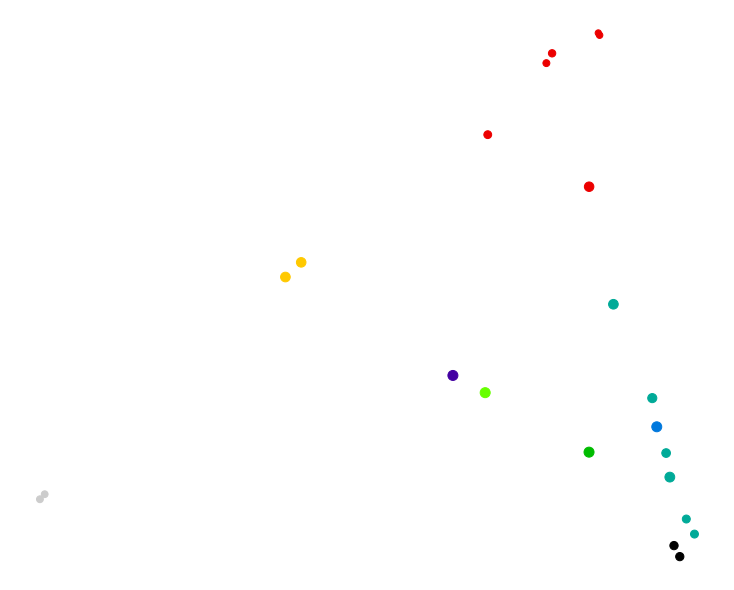

In [71]:
# #############################################################################
# Visualization
plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d ** 2, c=labels, cmap=plt.cm.nipy_spectral
)



In [72]:


# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)


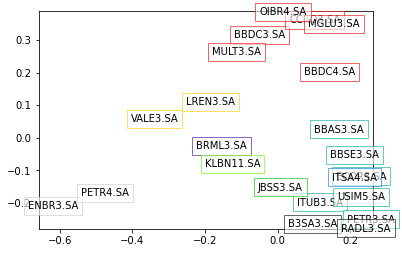

In [73]:

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()

In [51]:
movements = []

for df in dfs:
    movements.append(df.Close - df.Open)


  

In [52]:
normalized_movements = normalize(movements)

model = TSNE(learning_rate = 50)

In [53]:
tsne_features = model.fit_transform(normalized_movements)
xs = tsne_features[:,0]
ys = tsne_features[:,1]

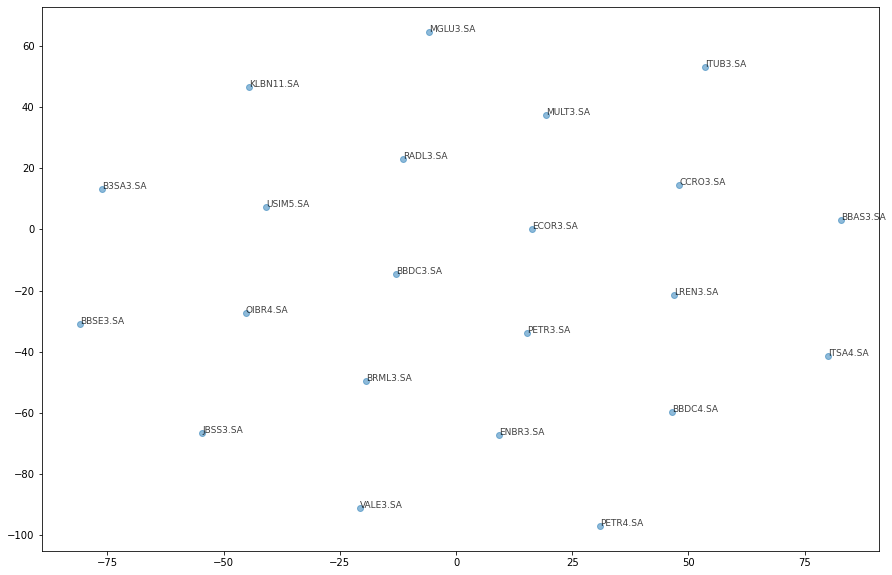

In [54]:
fig, ax = plt.subplots(figsize = [15, 10])
plt.scatter(xs, ys, alpha = 0.5)
for x, y, acao in zip(xs, ys, acoes):
    plt.annotate(acao, (x, y), fontsize=9, alpha=0.75)
plt.tight_layout
plt.show()